In [1]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer

from kneed import KneeLocator
from ast import literal_eval

# Define Functions for Pipeline

In [2]:
def column_extractor(feature_list):
    feature_list = [
        list(map(float, item.strip('[]').split(',')))
        for item in feature_list
    ]
    return np.array(feature_list)

def data_loader(path):
    metadata = pd.read_csv(path)
    image_paths = metadata.Image.tolist()
    features = np.concatenate([
        column_extractor(metadata.Color.tolist()),
        column_extractor(metadata.Glcm.tolist()),
        column_extractor(metadata.Gccrop.tolist()),
        column_extractor(metadata.Lbp.tolist()),
    ], axis=1)
    columns = [f'F_{i:0>3}' for i in range(len(features))]
    features = pd.DataFrame(features, columns)
    feat2drop = features.loc[:, features.var(axis=0) == 0].columns
    features.drop(feat2drop, axis=1, inplace=True)
    return (image_paths, features)

def scaler(features, feat_range=(0, 1)):
    # can change for different type of scaling
    min_max_scaler = MinMaxScaler(feature_range=feat_range)
    min_max_scaler.fit(features)
    features = min_max_scaler.transform(features)
    return features

def pca_feature_selector(features, num_components=10):
    pca = PCA(n_components=num_components, random_state=25)
    pca.fit(features)
    features = pca.transform(features)
    return features

def clustering(features, num_clusters):
    model = KMeans(
        n_clusters=num_clusters,
        init="k-means++",
        n_init=50,
        max_iter=600,
        random_state=25,
     )
    model.fit(features)
    return model

def scoring(features, labels):
    return silhouette_score(features, labels)

def visualizer(scores, ticks, xlabel, ylabel, title, ticklabels=None,):
    plt.figure(figsize=(10, 10))
    plt.xticks(ticks=ticks, labels=ticklabels)
    plt.plot(range(len(scores)),
             scores,
             c='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Load in Segmented Features

In [5]:
# change path name to cluster different features
data_paths, original_features = data_loader('ImageProcessingPipeline/data/processed/real_features.csv')
original_features.shape

(1590, 1835)

# Parameter Tuning for PCA

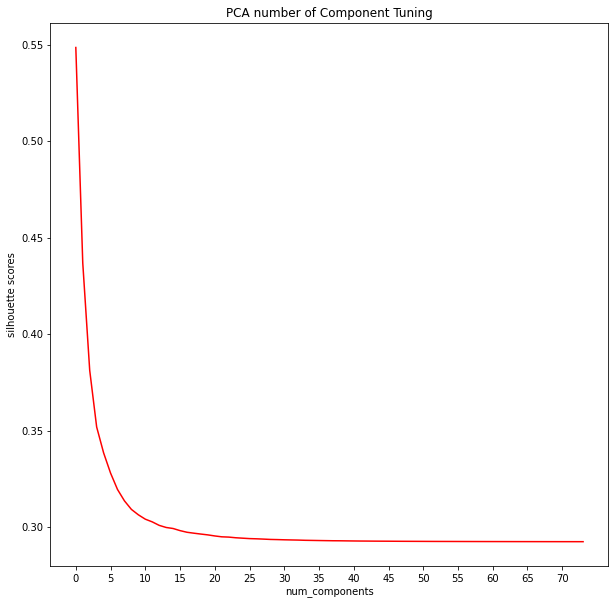

In [8]:
silhouette_scores = []

for n in range(1, 75, 1):
    features = original_features.values.copy()
    #features = scaler(features, feat_range=(0, 1))
    features = pca_feature_selector(features, num_components=n)
    model = clustering(features, num_clusters=8)
    silhouette_scores.append(scoring(features, model.labels_))

# Visualize the resutls.
visualizer(silhouette_scores,
           ticks=range(0, 75,5),
           xlabel='num_components',
           ylabel='silhouette scores',
           title='PCA number of Component Tuning')

# Parameter tuning with kmeans

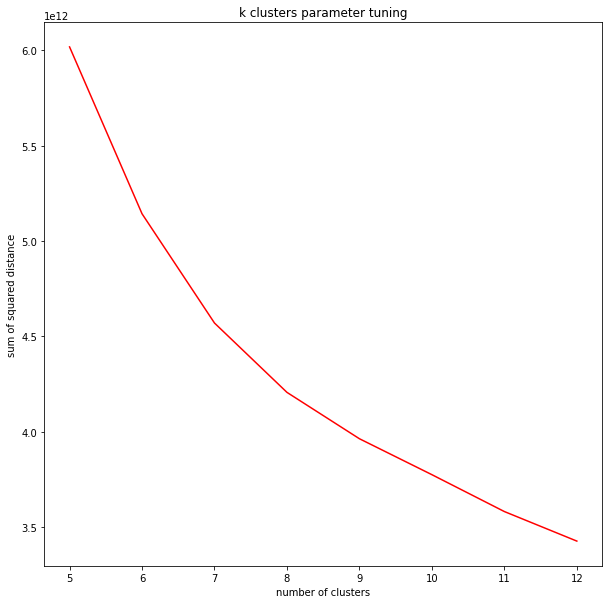

7


In [9]:
sse = []
list_k = list(range(5, 13))

for k in list_k:
    features = original_features.values.copy()
    model = clustering(features, num_clusters=k)
    sse.append(model.inertia_)
# Plot sse against k
visualizer(sse,
           ticks=range(0,8),
           ticklabels=['5', '6', '7', '8', '9', '10', '11', '12'],
           xlabel='number of clusters',
           ylabel='sum of squared distance',
           title='k clusters parameter tuning')

kl = KneeLocator(
    range(5, 13), sse, curve="convex", direction="decreasing"
)

print(kl.elbow)

# Test a Pipeline

In [10]:
features = original_features.values.copy()

# can comment out if scaling/pca not wanted
features = scaler(features)
features = pca_feature_selector(features, num_components=40)

model = clustering(features, num_clusters=8)
labels = model.labels_
scoring(features, labels)

0.18391156239169637

In [11]:
results = pd.DataFrame([data_paths, labels]).T
results.rename(columns = {0:'path', 1:'label'}, inplace = True)
results

,path,label
0,data/processed/real_regions/0000_16401081_1.png,1
1,data/processed/real_regions/0001_16401081_10.png,1
2,data/processed/real_regions/0002_16401081_11.png,1
3,data/processed/real_regions/0003_16401081_12.png,1
4,data/processed/real_regions/0004_16401081_14.png,4
...,...,...
1585,data/processed/real_regions/1585_16401081_49.png,5
1586,data/processed/real_regions/1586_16401081_50.png,1
1587,data/processed/real_regions/1587_16401081_6.png,5
1588,data/processed/real_regions/1588_16401081_7.png,5


In [12]:
groups = results.groupby('label')['path']
groups.count()

label
0     86
1    290
2    226
3    340
4     70
5    215
6    328
7     35
Name: path, dtype: int64

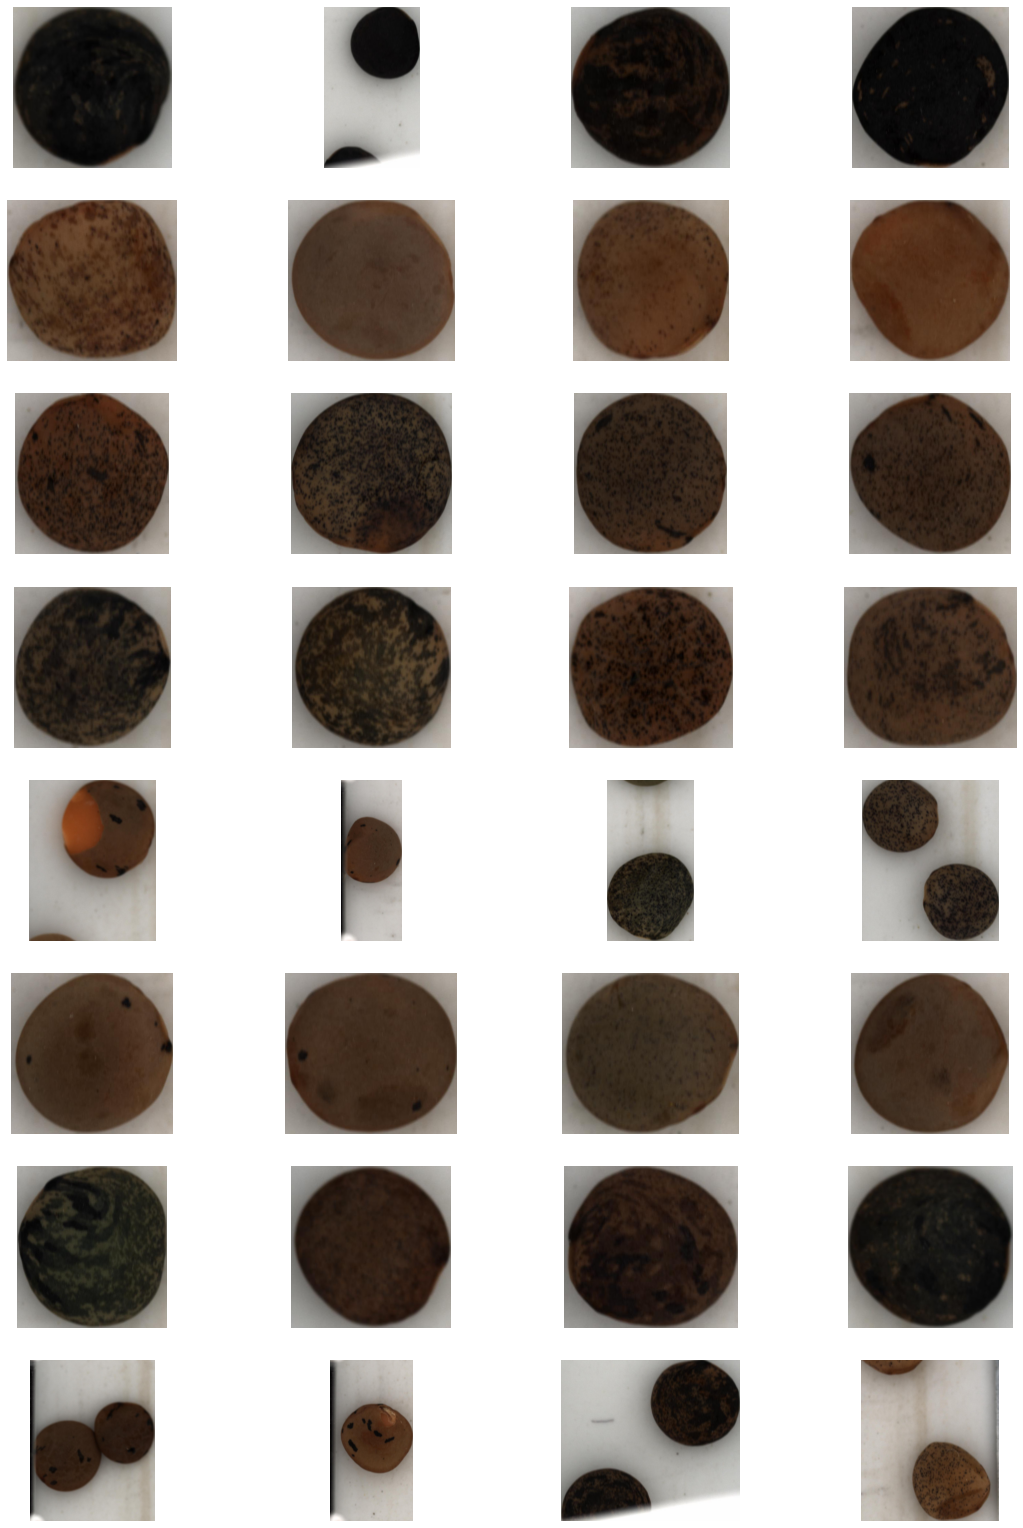

In [13]:
fig = plt.figure(figsize=(85, 85))
plt.subplots_adjust(bottom=0.1, right=0.3, top=0.6)
columns = 4
rows = 16
# show 4 images in a row from each cluster
for i in range(8):
    cluster = groups.get_group(i).tolist()
    for j in range(0, 4):
        # select an image to plot and then remove it so it is not plotted twice
        img_path = random.choice(cluster)
        #remove image from group so it is not visualized twice
        cluster.remove(img_path)
        # may have to change path to plot the image
        img = io.imread('ImageProcessingPipeline/'+img_path)
        #place at row 4i and column j+1
        fig.add_subplot(rows, columns, (4*i+(j+1)))
        plt.imshow(img)
        plt.axis('off')

In [57]:
# change pathname to where you want to save cluster results to
results.to_csv('results/8_clusters.csv')